In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import py_dss_interface
from datetime import datetime
plt.style.use('..\matplot.mplstyle')

In [ ]:
rng = np.random.default_rng(123)
dss = py_dss_interface.DSSDLL()
dss.text(r"clear")

dss.text(r"Compile C:\Users\kaioh\Documents\Mestrado\Impactos_GD\projeto\opendss_network\Master_RS2.dss")

# LoadShape das 88 residencias
pow_houses = pd.read_csv(r"C:\Users\kaioh\Documents\Mestrado\Impactos_GD\projeto\input\LoadShape48h_DemMed.csv", delimiter=';', header=None).values
pow_houses = pow_houses[:, 0:144]


dss.text("Set mode=daily")
dss.text("Set number=1")
dss.text("Set stepsize=10m")

demand_p = np.empty((3, time*N, 88))
demand_p.fill(np.nan)
demand_q = np.empty((3, time*N, 88))
demand_q.fill(np.nan)

p_trafo = np.zeros((3, time*N, 1))
q_trafo = np.zeros((3, time*N, 1))

pc = np.zeros((88, 10))
# Generate mean and std for the normal distribution
mi_Pc = pow_houses[:, 89]
std = mi_Pc * 0.5
for load in range(88):
    pc[load] = rng.normal(mi_Pc[load],std[load],10)

dss.loads_first()
for c in range(88):
    # Adicionar a potencia que o PV gera nas barras [22, 44, 36, 11, 32] idx[11,31,44,64,73]
    if dss.loads_read_name() in ['consumidor_575', 'consumidor_364', 'consumidor_345', 'consumidor_555', 'consumidor_288']:
        dss.loads_write_kw((float(pc[c, 0] - pv[0, 89])))
    else:
        dss.loads_write_kw(float(pc[c, 0]))
    dss.loads_next()

dss.solution_solve()
dss.circuit_set_active_element('Vsource.source')
print(dss.cktelement_powers())

dss.circuit_set_active_element('Transformer.trafoa')
print(dss.cktelement_num_phases())
print(dss.cktelement_powers())

for i, j in zip(range(3), [8, 10, 12]):
    p_trafo[i, 0] = dss.cktelement_powers()[j]*-1
    q_trafo[i, 0] = dss.cktelement_powers()[j+1]*-1


In [2]:
# Numeber of samples
N = 1000
# timesteps of 10min 
time = 144

# pv loadshape 1000 x 144
pv = np.load(r'../dataset\PV_Curves_Ijui_RS_1000_Samples_15_12-16_52.npz')
pv = pv['PV_s']

# random initializer
rng = np.random.default_rng()

dss = py_dss_interface.DSSDLL()
dss.text(r"clear")

dss.text(r"Compile C:\Users\kaioh\Documents\Mestrado\Impactos_GD\projeto\opendss_network\Master_RS2.dss")

# LoadShape das 88 residencias
pow_houses = pd.read_csv(r"C:\Users\kaioh\Documents\Mestrado\Impactos_GD\projeto\input\LoadShape48h_DemMed.csv", delimiter=';', header=None).values
pow_houses = pow_houses[:, 0:144]

# PV system
# dss.text('New XYCurve.MyPvsT npts=4  xarray=[0  25  75  100]  yarray=[1.2 1.0 0.8  0.6]')
# dss.text('New XYCurve.MyEff npts=4  xarray=[.1  .2  .4  1.0]  yarray=[.86  .9  .93  .97]')
# dss.text(f'New PVSystem.PV1 phases=3 bus1=barra4.1.2.3.4 kv=0.380 Pmpp=2.4 %cutin=0.1 %cutout=0.1 \
#            P-TCurve=MyPvsT effcurve=Myeff irrad={} temperature={} pf=1')

dss.text("Set mode=daily")
dss.text("Set number=1")
dss.text("Set stepsize=10m")

# Number of buses
nbus = dss.circuit_num_buses()
loads = 88
phases = 3
# Initialize the arrays for the P and Q load demands, Bus voltages 
# and Active power of transformers at buses 1 and 25 (in this file 0 and 24)
demand_p = np.zeros((phases, time*N, loads))
demand_p.fill(np.nan)
demand_q = np.zeros((phases, time*N, loads))
demand_q.fill(np.nan)
voltages = np.zeros((phases, time*N, nbus))
voltages.fill(np.nan)
p_trafo = np.zeros((phases, time*N, 1))
q_trafo = np.zeros((phases, time*N, 1))


# Stores the active power generated by the monte carlo for every load in the system
pc = np.zeros((88, N))

for t in range(144):
    # Generate mean and std for the normal distribution
    mi_Pc = pow_houses[:, t]
    std = mi_Pc * 0.1
    for load in range(88):
        pc[load] = rng.normal(mi_Pc[load],std[load],N)
    
    
    # Loop in every Monte Carlo sample for every timestep
    for n in range(N):
        # Update the network loads with the generated loadshapes
        dss.loads_first()
        for c in range(88):
            # Adicionar a potencia que o PV gera nas barras [22, 44, 36, 11, 32]
            if dss.loads_read_name() in ['consumidor_575', 'consumidor_364', 'consumidor_345', 'consumidor_555', 'consumidor_288']:
                dss.loads_write_kw(float(pc[c, n] - pv[n, t]))
            else:
                dss.loads_write_kw(float(pc[c, n]))
            
            dss.loads_next()
        
        # Solve do opendss
        dss.solution_solve()

        # Adding the transformer values
        # It starts in the 8th index because the previous ones are from the MV side
        dss.circuit_set_active_element('Transformer.trafoa')
        for i, j in zip(range(phases), [8, 10, 12]):
            p_trafo[i, t + (time*n)] = dss.cktelement_powers()[j]*-1
            q_trafo[i, t + (time*n)] = dss.cktelement_powers()[j+1]*-1

        # Preenchendo os valores de demanda em cada fase
        dss.loads_first()
        for c in range(88):
            # Lê a barra e separa a string por ponto para podermos usar a fase como index da demanda
            phase_idx = dss.cktelement_read_bus_names()[0].split('.')
            # Avalia quando a carga é mono, bi, ou trifásica e preenche na fase correta
            if dss.cktelement_num_phases() == 1:
                demand_p[int(phase_idx[1])-1, t + (time*n), c] = dss.cktelement_powers()[0]
                demand_q[int(phase_idx[1])-1, t + (time*n), c] = dss.cktelement_powers()[1]
            elif dss.cktelement_num_phases() == 2:
                demand_p[int(phase_idx[1])-1, t + (time*n), c] = dss.cktelement_powers()[0]
                demand_q[int(phase_idx[1])-1, t + (time*n), c] = dss.cktelement_powers()[1]
                demand_p[int(phase_idx[2])-1, t + (time*n), c] = dss.cktelement_powers()[2]
                demand_q[int(phase_idx[2])-1, t + (time*n), c] = dss.cktelement_powers()[3]
            elif dss.cktelement_num_phases() == 3:
                demand_p[int(phase_idx[1])-1, t + (time*n), c] = dss.cktelement_powers()[0]
                demand_q[int(phase_idx[1])-1, t + (time*n), c] = dss.cktelement_powers()[1]
                demand_p[int(phase_idx[2])-1, t + (time*n), c] = dss.cktelement_powers()[2]
                demand_q[int(phase_idx[2])-1, t + (time*n), c] = dss.cktelement_powers()[3]
                demand_p[int(phase_idx[3])-1, t + (time*n), c] = dss.cktelement_powers()[4]
                demand_q[int(phase_idx[3])-1, t + (time*n), c] = dss.cktelement_powers()[5]
            dss.loads_next()
        
        # Tensão de cada nó do sistema (ex: tensão 1,2,3 e 4 do bus5)
        # Como algumas barras não tem o nó .4 adiciona np.nan nas posições onde seria a barraX.4, mas que não existem.
        # Assim conseguimos criar um array com 200 tensões (ao invés de 193) de cada fase da barra (.1 .2 .3 .4)
        # para que a relação com o bus_names (que tem 50 buses) faça sentido.  
        temp = np.insert(np.array(dss.circuit_all_bus_vmag_pu()), [3, 35, 36, 119, 126, 139, 140], np.nan)
        # Remove os nós .4 que não serviam para o objetivo do trabalho
        temp = np.delete(temp, np.arange(3,200,4))
        for j in range(0, 150, 3):
            voltages[0, t + (time*n), int(j/3)] = temp[j]
            voltages[1, t + (time*n), int(j/3)] = temp[j+1]
            voltages[2, t + (time*n), int(j/3)] = temp[j+2]
        
    
# Save all this data in a numpy file format
date = datetime.now().strftime('%d_%m-%H_%M')
np.savez(fr"C:\Users\kaioh\Documents\Universidade\State Estimation\dataset/MC_3phase_std_05_samples_{N}_{date}", demand_p=demand_p, demand_q=demand_q, voltages=voltages, p_trafo=p_trafo, q_trafo=q_trafo)
# To load the files use data = np.load(filename) and data['column']

OpenDSS Started successfully! 
OpenDSS Version 9.4.0.1 (64-bit build); License Status: Open 




In [11]:
mi_Pc.shape

(88,)

In [10]:
pc.shape

(88, 1000)

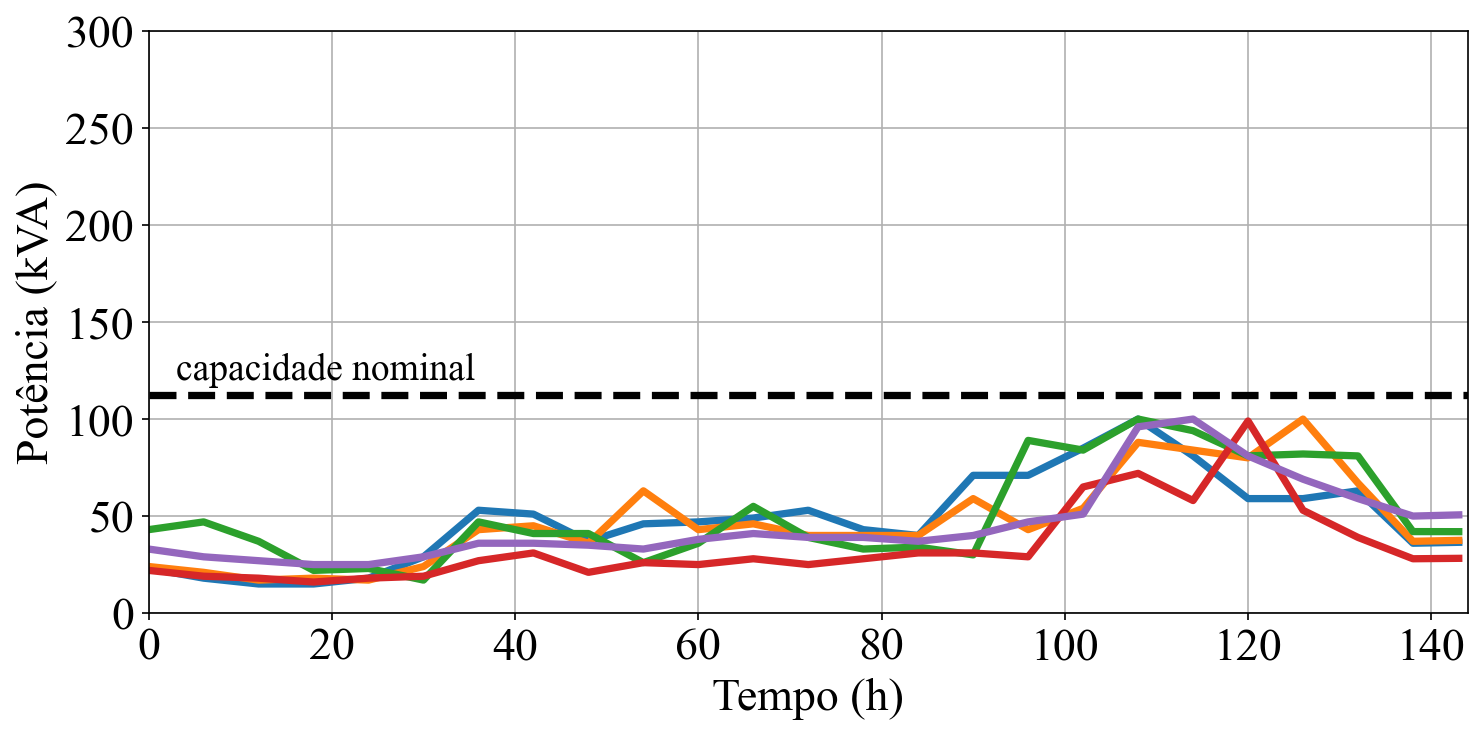

In [38]:
tempo = np.arange(144)
plt.figure(figsize = (10,5), dpi = 150)
for i in range(5):
    plt.plot(tempo, loadshapes[i]*100)
plt.ylabel('Potência (kVA)')
plt.xlabel('Tempo (h)')
plt.axhline(112.5, color="black", linestyle="--")
plt.text(3, 125, 'capacidade nominal', fontsize=18, va='center', ha='left')
#plt.xticks(np.arange(0, 289, 12), ('0h', '2h', '4h', '6h', '8h', '10h', '12h', '14h','16h', '18h', '20h', '22h', '0h', '2h', '4h', '6h', '8h', '10h', '12h', '14h','16h', '18h', '20h', '22h', '24h'))
# plt.xticks(np.arange(0, 289, 12), ('0', '2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '0', '2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24'))
plt.xlim(0, 144)
plt.ylim(0, 300)
plt.margins(x=0)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()